<a href="https://colab.research.google.com/github/talisma-cassoma/plant-disease-study/blob/main/mobilenet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANALISE EXPLORATORIA DO DATASET

clone the repo PlantDoc dataset repo

In [ ]:
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2670 (delta 23), reused 40 (delta 22), pack-reused 2628 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

# Carregar o dataset da estrutura atual
builder = tfds.folder_dataset.ImageFolder('/content/PlantDoc-Dataset')

# Exibir informações sobre o dataset
print(builder.info)

# Criar o conjunto de dados para treino e teste
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)

# Dividir o conjunto de treino em treino e validação manualmente
dataset_size = raw_train.cardinality().numpy()  # Tamanho total do conjunto de treino
validation_size = int(0.2 * dataset_size)       # 20% dos dados para validação

# Dividir o conjunto de treino
raw_train_valid = raw_train.skip(validation_size)  # 80% para treino
raw_valid = raw_train.take(validation_size)        # 20% para validação

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=34),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '.git': <SplitInfo num_examples=unknown, num_shards=1>,
        'test': <SplitInfo num_examples=236, num_shards=1>,
        'train': <SplitInfo num_examples=2342, num_shards=1>,
    },
    citation="""""",
)


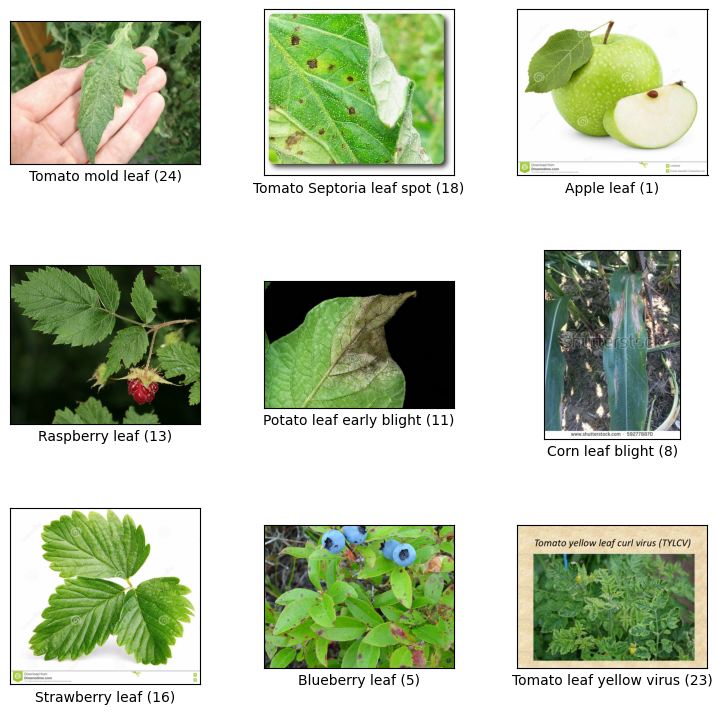

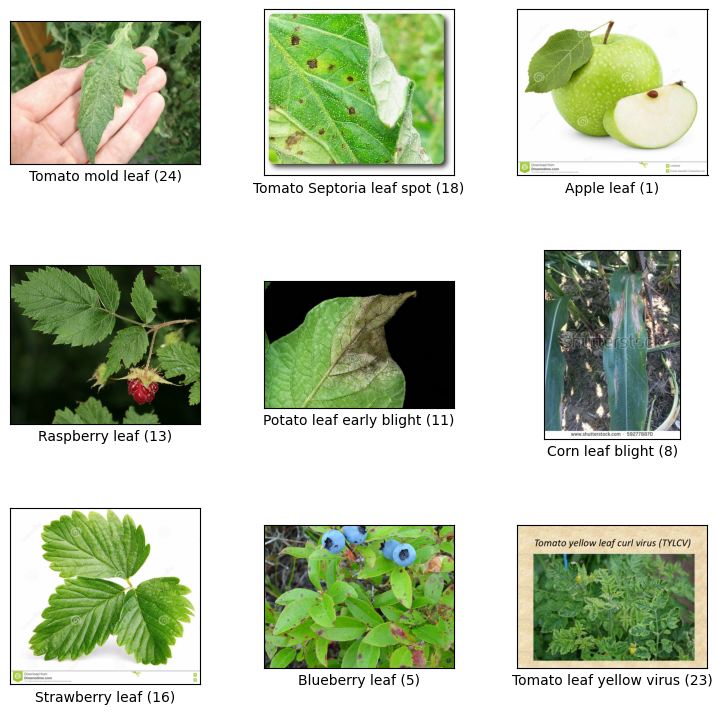

In [ ]:
tfds.show_examples(raw_train, builder.info)

# Data processing

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# Mobilenet

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="MobileNetV3Small",
)

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 576)


In [ ]:
# freeze the convolutional layers to use the base model as a feature extractor
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, None, None, 16) │            432 │ rescaling_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, None, None, 16) │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, None, None, 16) │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 16) │              0 │ activation_36[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 16) │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 16) │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)           │ (None, None, None, 16) │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_28[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_29 (ReLU)      

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

ValueError: Undefined shapes are not supported.

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 510ms/step - accuracy: 0.0409 - loss: 2.3510


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.36
initial accuracy: 0.04


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 92s 849ms/step - accuracy: 0.0295 - loss: -0.2421 - val_accuracy: 0.0427 - val_loss: -6.4552
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 95s 849ms/step - accuracy: 0.0400 - loss: -8.3264 - val_accuracy: 0.0299 - val_loss: -14.2425
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 132s 844ms/step - accuracy: 0.0294 - loss: -16.4815 - val_accuracy: 0.0470 - val_loss: -22.1636
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 133s 707ms/step - accuracy: 0.0313 - loss: -23.8784 - val_accuracy: 0.0321 - val_loss: -30.1549
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 732ms/step - accuracy: 0.0345 - loss: -31.8997 - val_accuracy: 0.0470 - val_loss: -35.7313
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 732ms/step - accuracy: 0.0322 - loss: -39.1541 - val_accuracy: 0.0363 - val_loss: -42.7200
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 719ms/step - accuracy: 0.0278 - loss: -48.0135 - val_accuracy: 0.0449 - val_loss: -50.8204
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 806ms/step - accuracy: 0.032

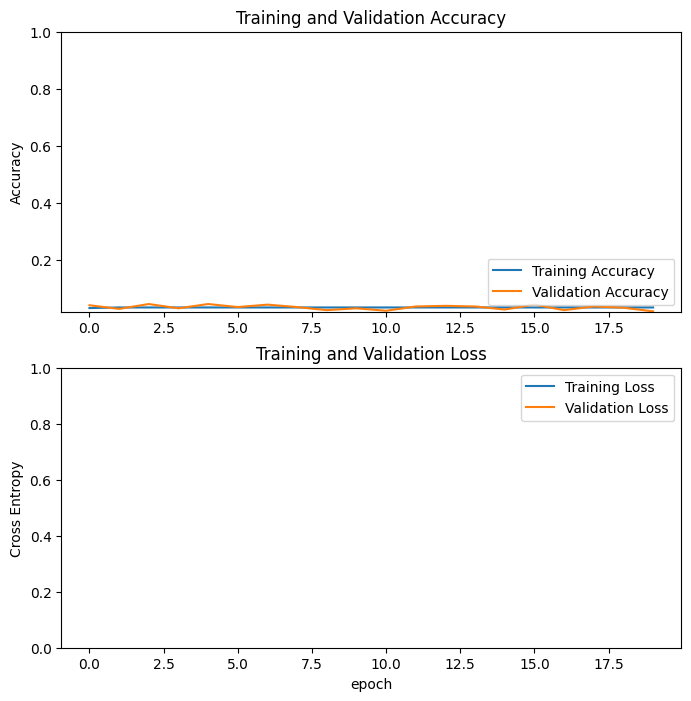

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  157


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 5, 5, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 939,697 (3.58 MB)

 Trainable params: 755,777 (2.88 MB)

 Non-trainable params: 183,920 (718.44 KB)

In [ ]:
len(model.trainable_variables)

51

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 110s 974ms/step - accuracy: 0.0339 - loss: 246.3577 - val_accuracy: 0.0278 - val_loss: -152.4170
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 93s 935ms/step - accuracy: 0.0325 - loss: 192.5175 - val_accuracy: 0.0342 - val_loss: -155.0962
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 84s 849ms/step - accuracy: 0.0340 - loss: 145.1083 - val_accuracy: 0.0342 - val_loss: -155.9456
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 152s 975ms/step - accuracy: 0.0421 - loss: 100.5769 - val_accuracy: 0.0128 - val_loss: -151.1708
Epoch 24/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 85s 858ms/step - accuracy: 0.0381 - loss: 62.8658 - val_accuracy: 0.0321 - val_loss: -147.1946
Epoch 25/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 853ms/step - accuracy: 0.0354 - loss: 31.5137 - val_accuracy: 0.0299 - val_loss: -145.5150
Epoch 26/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 93s 927ms/step - accuracy: 0.0232 - loss: 0.5723 - val_accuracy: 0.0299 - val_loss: -146.9459
Epoch 27/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 132s 855ms/step -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

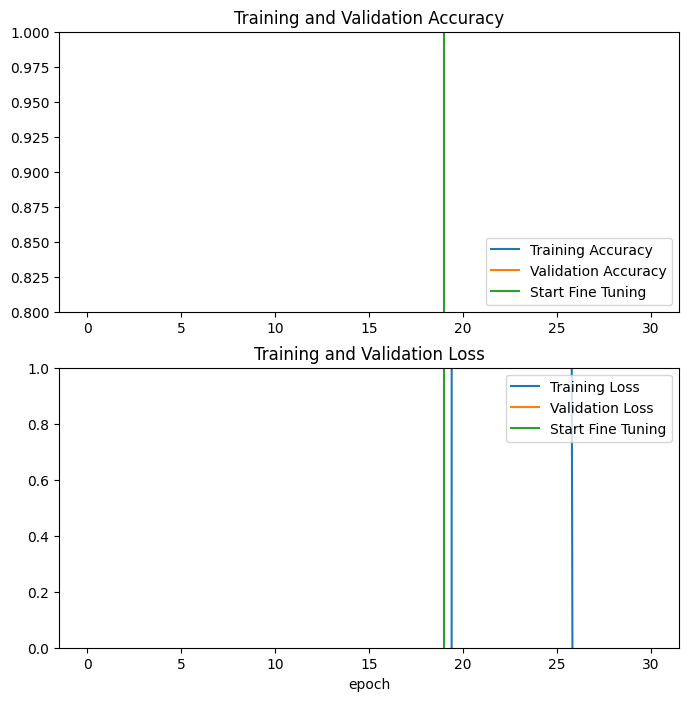

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

objectivos
- analise exploratria
  - [ ] numero de imagens no dataset
  - [ ] numero de cada categiria em forma de tabela
- treino do modelo
 - [ ] pre-processamento
 - [x] treino
 - [ ] salvar modelo
 - [ ] ler modelo
 - [ ] testes